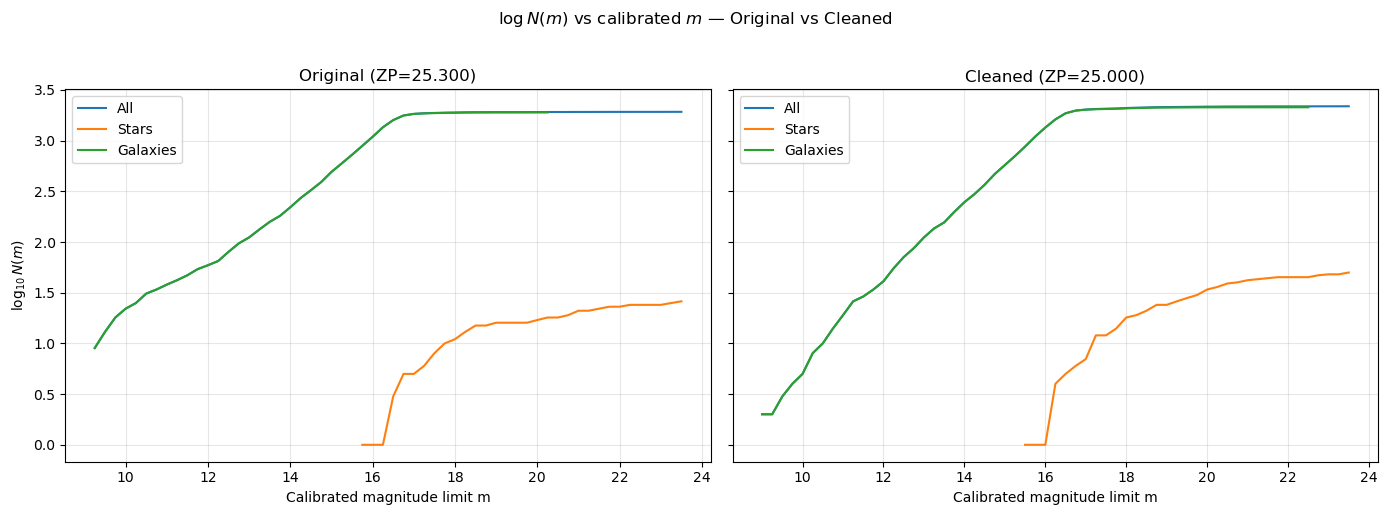

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage as ndi

FILES = [
    ("Original", "mosaic.fits"),
    ("Cleaned",  "mosaic_cleaned_enhanced.fits"),
]


ZP_MANUAL = 25.3

BAD_VALUE = 3421.0
SAT_LEVEL = 36000.0

PIX_SCALE = 0.258
ZP_KEY = "MAGZPT"

R_AP = 1.5 / PIX_SCALE
R_IN = R_AP + 3.0
R_OUT = R_AP + 8.0

DETECT_SIGMA = 5.0
MIN_AREA = 6
EDGE_PAD = int(np.ceil(R_OUT + 2))

R_SMALL = 2.0
STAR_C_MAX = 0.8
STAR_RE_MAX = 3.8

DM = 0.25


def bg_sigma(image, bad_value=BAD_VALUE):
    flat = image.ravel()
    flat = flat[np.isfinite(flat) & (flat != bad_value)]
    med = float(np.median(flat))
    mad = float(np.median(np.abs(flat - med)))
    sig = float(1.4826 * mad) if mad > 0 else float(np.std(flat))
    return med, sig
import numpy as np
import matplotlib.pyplot as plt

# galaxies-only cumulative curve
m_grid_g, logN_g = logN_curve(m_cal[is_gal], dm=DM)

# guard
if m_grid_g is None or logN_g is None:
    raise RuntimeError("Not enough galaxy magnitudes to build logN curve.")

# Reconstruct N on the SAME grid as logN_g
mask0 = np.isfinite(logN_g)
N_grid = np.zeros_like(m_grid_g, int)
N_grid[mask0] = np.round(10**logN_g[mask0]).astype(int)

# Basic mask (avoid N<20)
mask = mask0 & (N_grid >= 20)
m = m_grid_g[mask]
y = logN_g[mask]
N = N_grid[mask]

# Poisson error in log10 N
sigma_y = 1.0 / (np.log(10.0) * np.sqrt(N))

# choose fit region robustly
fit = np.ones_like(m, dtype=bool)

# avoid tiny-N bright end
fit &= (N >= 20)

# avoid incompleteness / flat tail
Nmax = np.max(N)
fit &= (N <= 0.95 * Nmax)

# avoid slope collapse
dy = np.gradient(y, m)
fit &= (dy > 0.15)

mf = m[fit]
yf = y[fit]
sf = sigma_y[fit]

if mf.size < 3:
    raise RuntimeError("Fit window too small. Loosen dy threshold or Nmax cut.")

# weighted least squares: y = a*m + b
w = 1.0 / (sf**2)
A = np.vstack([mf, np.ones_like(mf)]).T
Aw = A * np.sqrt(w)[:, None]
yw = yf * np.sqrt(w)
(a, b), *_ = np.linalg.lstsq(Aw, yw, rcond=None)

# parameter uncertainties from covariance
cov = np.linalg.inv(A.T @ (w[:, None] * A))
sa = np.sqrt(cov[0, 0])
sb = np.sqrt(cov[1, 1])

print(f"Weighted fit (galaxies): slope a = {a:.3f} ± {sa:.3f}, intercept b = {b:.2f} ± {sb:.2f}")
print(f"Fit range: m in [{mf.min():.2f}, {mf.max():.2f}], points={mf.size}")

# Plot
plt.figure(figsize=(7, 5))

# data (galaxies only, N>=20)
plt.errorbar(m, y, yerr=sigma_y, fmt="o", ms=3, capsize=2, label="galaxies (Poisson err)")

# show excluded points faintly
m_ex = m[~fit]
y_ex = y[~fit]
if m_ex.size:
    plt.scatter(m_ex, y_ex, s=10, alpha=0.25, label="excluded from fit")

# fit line on the fitted region
m_line = np.linspace(mf.min(), mf.max(), 200)
plt.plot(m_line, a*m_line + b, lw=2, label=f"weighted fit: {a:.3f}±{sa:.3f}")

plt.xlabel("Calibrated magnitude limit m")
plt.ylabel(r"$\log_{10} N(m)$")
plt.title("log N(m) vs m (galaxies) with Poisson-weighted fit")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


def aperture_photometry(img, x0, y0, r_ap, r_in, r_out, bad_value=BAD_VALUE):
    ny, nx = img.shape
    if x0 < EDGE_PAD or x0 > nx-1-EDGE_PAD or y0 < EDGE_PAD or y0 > ny-1-EDGE_PAD:
        return {"ok": False}

    rbox = int(np.ceil(r_out + 2))
    x0f, y0f = float(x0), float(y0)
    x1 = max(0, int(np.floor(x0f)) - rbox); x2 = min(nx-1, int(np.floor(x0f)) + rbox)
    y1 = max(0, int(np.floor(y0f)) - rbox); y2 = min(ny-1, int(np.floor(y0f)) + rbox)

    patch = img[y1:y2+1, x1:x2+1]
    yy, xx = np.ogrid[y1:y2+1, x1:x2+1]
    rr2 = (xx - x0f)**2 + (yy - y0f)**2

    bad = (~np.isfinite(patch)) | (patch == bad_value)
    ap  = (rr2 <= r_ap**2) & (~bad)
    ann = (rr2 >= r_in**2) & (rr2 <= r_out**2) & (~bad)

    Nap, Nann = int(ap.sum()), int(ann.sum())
    if Nap < 10 or Nann < 30:
        return {"ok": False}

    ap_vals = patch[ap]
    ann_vals = patch[ann]
    bkg = float(np.median(ann_vals))
    flux_net = float(ap_vals.sum() - bkg * Nap)

    return {"ok": np.isfinite(flux_net) and (flux_net > 0), "flux_net": flux_net}


def flux_to_cal_mag(F, ZP):
    return float(ZP - 2.5 * np.log10(F))


def detect_sources(img):
    bg, sig = bg_sigma(img, BAD_VALUE)
    thr = bg + DETECT_SIGMA * sig
    valid = np.isfinite(img) & (img != BAD_VALUE)
    det = valid & (img >= thr) & (img < SAT_LEVEL)

    labels, nlab = ndi.label(det, structure=np.ones((3,3), int))
    slices = ndi.find_objects(labels)

    cat = []
    ny, nx = img.shape
    for lab_id, slc in enumerate(slices, start=1):
        if slc is None:
            continue
        m = (labels[slc] == lab_id)
        area = int(m.sum())
        if area < MIN_AREA:
            continue

        sub = img[slc]
        tmp = np.where(m, sub, -np.inf)
        iy, ix = np.unravel_index(int(np.argmax(tmp)), tmp.shape)
        y_peak = slc[0].start + iy
        x_peak = slc[1].start + ix

        vals = sub[m] - bg
        vals = np.clip(vals, 0, None)
        if vals.sum() > 0:
            ys, xs = np.nonzero(m)
            y_cent = float(slc[0].start + np.sum(ys * vals) / np.sum(vals))
            x_cent = float(slc[1].start + np.sum(xs * vals) / np.sum(vals))
        else:
            y_cent, x_cent = float(y_peak), float(x_peak)

        if x_cent < EDGE_PAD or x_cent > nx-1-EDGE_PAD or y_cent < EDGE_PAD or y_cent > ny-1-EDGE_PAD:
            continue

        r_eq = float(np.sqrt(area / np.pi))
        cat.append({"x": x_cent, "y": y_cent, "r_eq": r_eq})

    return cat


def classify_and_mags(img, cat, ZP):
    mags = np.full(len(cat), np.nan, float)
    C = np.full(len(cat), np.nan, float)

    for i, o in enumerate(cat):
        p_big = aperture_photometry(img, o["x"], o["y"], R_AP, R_IN, R_OUT, BAD_VALUE)
        p_sml = aperture_photometry(img, o["x"], o["y"], R_SMALL, R_IN, R_OUT, BAD_VALUE)
        if p_big["ok"] and p_sml["ok"]:
            m_big = flux_to_cal_mag(p_big["flux_net"], ZP)
            m_sml = flux_to_cal_mag(p_sml["flux_net"], ZP)
            mags[i] = m_big
            C[i] = float(m_sml - m_big)

    r_eq = np.array([o["r_eq"] for o in cat], float)
    ok = np.isfinite(mags) & np.isfinite(C) & np.isfinite(r_eq)

    is_star = np.zeros(len(cat), dtype=bool)
    is_star[ok] = (C[ok] <= STAR_C_MAX) & (r_eq[ok] <= STAR_RE_MAX)
    is_gal = ok & (~is_star)
    return mags, is_star, is_gal


def logN_curve(mags, dm=DM):
    mags = mags[np.isfinite(mags)]
    mags.sort()
    if mags.size < 5:
        return None, None
    m_grid = np.arange(np.floor(mags.min()/dm)*dm, np.ceil(mags.max()/dm)*dm + dm, dm)
    N = np.searchsorted(mags, m_grid, side="right")
    y = np.full_like(m_grid, np.nan, float)
    ok = N > 0
    y[ok] = np.log10(N[ok])
    return m_grid, y



# run and plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, (label, path) in zip(axes, FILES):
    with fits.open(path) as hdul:
        img = hdul[0].data.astype(float)
        hdr = hdul[0].header

    ZP = hdr.get(ZP_KEY, None)
    if ZP is None:
        ZP = ZP_MANUAL

    cat = detect_sources(img)
    mags, is_star, is_gal = classify_and_mags(img, cat, ZP)

    m_all, y_all = logN_curve(mags)
    m_s, y_s = logN_curve(mags[is_star])
    m_g, y_g = logN_curve(mags[is_gal])

    ax.plot(m_all, y_all, label="All")
    if m_s is not None: ax.plot(m_s, y_s, label="Stars")
    if m_g is not None: ax.plot(m_g, y_g, label="Galaxies")
    ax.set_title(f"{label} (ZP={ZP:.3f})")
    ax.set_xlabel("Calibrated magnitude limit m")
    ax.grid(True, alpha=0.3)
    ax.legend()

axes[0].set_ylabel(r"$\log_{10} N(m)$")
fig.suptitle(r"$\log N(m)$ vs calibrated $m$ — Original vs Cleaned", y=1.02)
plt.tight_layout()
plt.show()


In [7]:
# Plot the detections of sources and plot log N vs. calibrated magnitude with kth_nearest_neighbours filter

import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage as ndi
from scipy.spatial import cKDTree


INPUT_FITS = "mosaic_cleaned_enhanced.fits"
OUT_DIR = os.path.join(os.getcwd(), "outputs")
os.makedirs(OUT_DIR, exist_ok=True)

OUT_OVERLAY_JPG = os.path.join(OUT_DIR, "detections_overlay_densehalo_removed.jpg")
OUT_LOGN_JPG    = os.path.join(OUT_DIR, "logN_vs_calibrated_m.jpg")

BAD_VALUE = 3421.0
SAT_LEVEL = 36000.0

# Detection
DETECT_SIGMA = 5.0
MIN_AREA = 6

# Overlay display
CIRCLE_RADIUS_PX = 6
CIRCLE_LW = 0.6
DOWNSAMPLE = 2
P_LOW, P_HIGH = 5.0, 99.7

# kNN density removal
KNN_K = 10
CROWDED_FRACTION = 0.09
GRID = 10
HOT_PERCENTILE = 99
DILATE_CELLS = 3
MIN_REGION_CELLS = 12

# Photometry
PIX_SCALE = 0.258
R_AP  = 1.5 / PIX_SCALE
R_IN  = R_AP + 3.0
R_OUT = R_AP + 8.0
EDGE_PAD = int(np.ceil(R_OUT + 2))

# Calibration
ZP = 25.3
K_EXT = None
AIRMASS = None

# logN binning
DM = 0.25

def bg_sigma(image, bad_value=BAD_VALUE):
    v = image.ravel()
    v = v[np.isfinite(v) & (v != bad_value)]
    bg = float(np.median(v))
    mad = float(np.median(np.abs(v - bg)))
    sig = float(1.4826 * mad) if mad > 0 else float(np.std(v))
    return bg, sig

def detect_sources(img):
    bg, sig = bg_sigma(img, BAD_VALUE)
    thr = bg + DETECT_SIGMA * sig

    valid = np.isfinite(img) & (img != BAD_VALUE)
    det = valid & (img >= thr) & (img < SAT_LEVEL)

    labels, nlab = ndi.label(det, structure=np.ones((3,3), int))
    slices = ndi.find_objects(labels)

    cat = []
    for lab_id, slc in enumerate(slices, start=1):
        if slc is None:
            continue
        m = (labels[slc] == lab_id)
        area = int(m.sum())
        if area < MIN_AREA:
            continue

        sub = img[slc]
        tmp = np.where(m, sub, -np.inf)
        iy, ix = np.unravel_index(int(np.argmax(tmp)), tmp.shape)
        y_peak = slc[0].start + iy
        x_peak = slc[1].start + ix

        vals = sub[m] - bg
        vals = np.clip(vals, 0, None)
        if vals.sum() > 0:
            ys, xs = np.nonzero(m)
            y_cent = float(slc[0].start + np.sum(ys * vals) / np.sum(vals))
            x_cent = float(slc[1].start + np.sum(xs * vals) / np.sum(vals))
        else:
            y_cent, x_cent = float(y_peak), float(x_peak)

        cat.append({"x": x_cent, "y": y_cent})

    info = {"bg": bg, "sigma": sig, "thr": float(thr), "n_labels": int(nlab), "n_cat": len(cat)}
    return cat, info

def stretch_for_display(img):
    good = np.isfinite(img) & (img != BAD_VALUE)
    v = img[good]
    lo = float(np.percentile(v, P_LOW))
    hi = float(np.percentile(v, P_HIGH))
    if hi <= lo:
        hi = lo + 1.0
    return lo, hi

def build_region_from_points(xs, ys, shape, grid=10, hot_percentile=90.0,
                             dilate_cells=3, min_region_cells=12):
    ny, nx = shape
    gx = int(np.ceil(nx / grid))
    gy = int(np.ceil(ny / grid))

    ix = np.clip((xs / grid).astype(int), 0, gx-1)
    iy = np.clip((ys / grid).astype(int), 0, gy-1)

    H = np.zeros((gy, gx), dtype=np.int32)
    np.add.at(H, (iy, ix), 1)

    nz = H[H > 0]
    if nz.size == 0:
        return None, {"note": "empty density grid"}

    thr = float(np.percentile(nz, hot_percentile))
    hot = H >= thr

    lab, nlab = ndi.label(hot, structure=np.ones((3,3), int))
    if nlab == 0:
        return None, {"note": "no hotspot", "thr": thr, "Hmax": int(H.max())}

    # choose component with largest total count
    best = None
    best_score = -1.0
    for k in range(1, nlab+1):
        comp = (lab == k)
        score = float(H[comp].sum())
        if score > best_score:
            best_score = score
            best = comp

    if int(best.sum()) < min_region_cells:
        return None, {"note": "hotspot too small", "thr": thr, "cells": int(best.sum()), "Hmax": int(H.max())}

    if dilate_cells and dilate_cells > 0:
        best = ndi.binary_dilation(best, iterations=int(dilate_cells))

    pix = np.kron(best.astype(np.uint8), np.ones((grid, grid), dtype=np.uint8)).astype(bool)
    pix = pix[:ny, :nx]

    info = {"grid": grid, "thr": thr, "hot_percentile": hot_percentile,
            "Hmax": int(H.max()), "region_cells": int(best.sum()), "region_score": best_score}
    return pix, info

def knn_filter(cat, shape):
    xs = np.array([o["x"] for o in cat], float)
    ys = np.array([o["y"] for o in cat], float)
    pts = np.column_stack([xs, ys])
    n = len(pts)

    if n < (KNN_K + 2):
        return cat, {"note": "too few points for kNN"}, None

    tree = cKDTree(pts)
    dists, _ = tree.query(pts, k=min(KNN_K + 1, n))  # includes self at 0
    dk = dists[:, -1]

    m = max(1, int(np.floor(CROWDED_FRACTION * n)))
    idx_crowded = np.argpartition(dk, m-1)[:m]
    crowd_x = xs[idx_crowded]
    crowd_y = ys[idx_crowded]

    region_mask, rinfo = build_region_from_points(
        crowd_x, crowd_y, shape,
        grid=GRID, hot_percentile=HOT_PERCENTILE,
        dilate_cells=DILATE_CELLS, min_region_cells=MIN_REGION_CELLS
    )

    info = {
        "k": KNN_K,
        "crowded_fraction": CROWDED_FRACTION,
        "crowded_pts": int(m),
        "dk_min": float(dk.min()),
        "dk_median": float(np.median(dk)),
        "dk_crowded_max": float(dk[idx_crowded].max()),
        "region_info": rinfo
    }

    if region_mask is None:
        keep = np.ones(n, dtype=bool)
        keep[idx_crowded] = False
        cat_f = [cat[i] for i in range(n) if keep[i]]
        info["removed"] = int((~keep).sum())
        info["kept"] = int(keep.sum())
        return cat_f, info, None

    xi = np.clip(xs.astype(int), 0, shape[1]-1)
    yi = np.clip(ys.astype(int), 0, shape[0]-1)
    bad = region_mask[yi, xi]
    keep = ~bad

    cat_f = [cat[i] for i in range(n) if keep[i]]
    info["removed"] = int(bad.sum())
    info["kept"] = int(keep.sum())
    return cat_f, info, region_mask

def aperture_flux_net(img, x0, y0):
    ny, nx = img.shape
    if x0 < EDGE_PAD or x0 > nx-1-EDGE_PAD or y0 < EDGE_PAD or y0 > ny-1-EDGE_PAD:
        return None

    rbox = int(np.ceil(R_OUT + 2))
    x0f, y0f = float(x0), float(y0)

    x1 = max(0, int(np.floor(x0f)) - rbox); x2 = min(nx-1, int(np.floor(x0f)) + rbox)
    y1 = max(0, int(np.floor(y0f)) - rbox); y2 = min(ny-1, int(np.floor(y0f)) + rbox)

    patch = img[y1:y2+1, x1:x2+1]
    yy, xx = np.ogrid[y1:y2+1, x1:x2+1]
    rr2 = (xx - x0f)**2 + (yy - y0f)**2

    bad = (~np.isfinite(patch)) | (patch == BAD_VALUE)
    ap  = (rr2 <= R_AP**2) & (~bad)
    ann = (rr2 >= R_IN**2) & (rr2 <= R_OUT**2) & (~bad)

    Nap, Nann = int(ap.sum()), int(ann.sum())
    if Nap < 10 or Nann < 30:
        return None

    ap_vals  = patch[ap]
    ann_vals = patch[ann]
    bkg = float(np.median(ann_vals))
    flux_net = float(ap_vals.sum() - bkg * Nap)

    if not (np.isfinite(flux_net) and flux_net > 0):
        return None
    return flux_net

def flux_to_cal_mag(F):
    m = float(ZP - 2.5*np.log10(F))
    if (K_EXT is not None) and (AIRMASS is not None):
        m = m - float(K_EXT) * float(AIRMASS)
    return m

def logN_curve(mags, dm=DM):
    mags = np.asarray(mags, float)
    mags = mags[np.isfinite(mags)]
    mags.sort()
    if mags.size < 5:
        return None, None
    m_grid = np.arange(np.floor(mags.min()/dm)*dm, np.ceil(mags.max()/dm)*dm + dm, dm)
    N = np.searchsorted(mags, m_grid, side="right")
    y = np.full_like(m_grid, np.nan, dtype=float)
    ok = N > 0
    y[ok] = np.log10(N[ok])
    return m_grid, y


# RUN
with fits.open(INPUT_FITS) as hdul:
    img = hdul[0].data.astype(float)

cat, dinfo = detect_sources(img)
print("[detect]", dinfo)

cat_f, knn_info, region_mask = knn_filter(cat, img.shape)
print("[kNN]", knn_info)

# overlay JPG (filtered detections)
xs = np.array([o["x"] for o in cat_f], float)
ys = np.array([o["y"] for o in cat_f], float)

ds = int(max(1, DOWNSAMPLE))
img_show = img[::ds, ::ds]
lo, hi = stretch_for_display(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_show, origin="lower", cmap="gray", vmin=lo, vmax=hi, interpolation="nearest")
plt.scatter(xs/ds, ys/ds,
            s=(2.0*(CIRCLE_RADIUS_PX/ds))**2,
            facecolors="none", edgecolors="red", linewidths=CIRCLE_LW)
plt.title(f"Detections overlay (N={len(xs)}) — dense halo removed by kNN density")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")
plt.tight_layout()
plt.savefig(OUT_OVERLAY_JPG, dpi=200, bbox_inches="tight")
plt.close()
print("Saved overlay:", OUT_OVERLAY_JPG)

# photometry and calibrated mags
m_cal = []
for o in cat_f:
    F = aperture_flux_net(img, o["x"], o["y"])
    m_cal.append(np.nan if F is None else flux_to_cal_mag(F))
m_cal = np.array(m_cal, float)
m_cal = m_cal[np.isfinite(m_cal)]

print("[phot] mags (cal) count:", m_cal.size)
if m_cal.size:
    print("[phot] m_cal min/median/max:", float(m_cal.min()), float(np.median(m_cal)), float(m_cal.max()))

# logN vs calibrated m plot
m_grid, logN = logN_curve(m_cal, dm=DM)

plt.figure(figsize=(7, 5))
plt.plot(m_grid, logN, marker="o", markersize=2, linewidth=1.2)
plt.xlabel("Calibrated magnitude limit m")
plt.ylabel(r"$\log_{10} N(m)$")
plt.title(r"$\log N(m)$ vs $m$ (calibrated, kNN-filtered)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_LOGN_JPG, dpi=200, bbox_inches="tight")
plt.close()
print("Saved logN:", OUT_LOGN_JPG)


[detect] {'bg': 3419.0, 'sigma': 13.343399999999999, 'thr': 3485.717, 'n_labels': 13846, 'n_cat': 2372}
[kNN] {'k': 10, 'crowded_fraction': 0.09, 'crowded_pts': 213, 'dk_min': 17.794045267402446, 'dk_median': 124.05809094222843, 'dk_crowded_max': 48.03914897828782, 'region_info': {'note': 'hotspot too small', 'thr': 3.0, 'cells': 1, 'Hmax': 3}, 'removed': 213, 'kept': 2159}
Saved overlay: C:\Users\wz2523\OneDrive - Imperial College London\Lab Astro\Astro\Astro\Fits_Data\outputs\detections_overlay_densehalo_removed.jpg
[phot] mags (cal) count: 2037
[phot] m_cal min/median/max: 9.10366636667963 15.982774648145446 21.47130270739436
Saved logN: C:\Users\wz2523\OneDrive - Imperial College London\Lab Astro\Astro\Astro\Fits_Data\outputs\logN_vs_calibrated_m.jpg


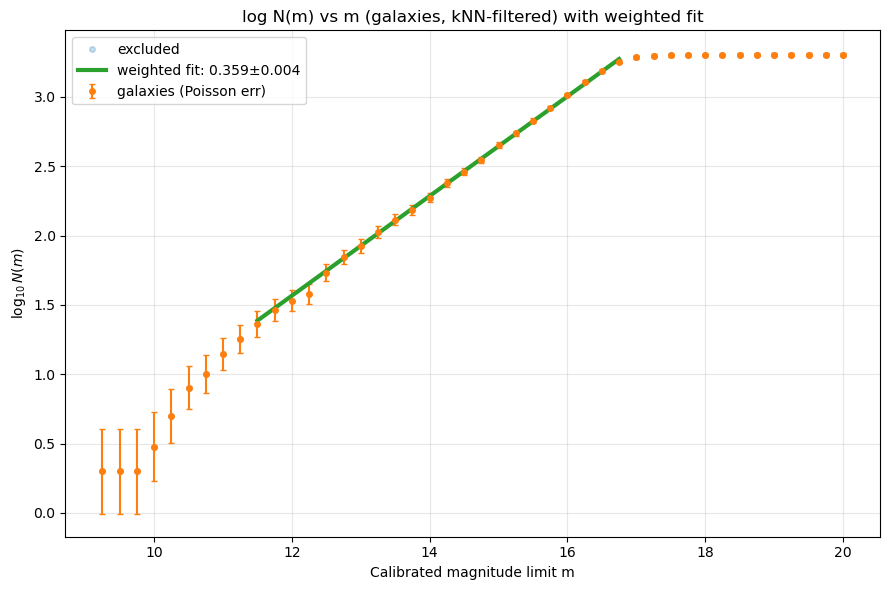

Saved: C:\Users\wz2523\OneDrive - Imperial College London\Lab Astro\Astro\Astro\Fits_Data\outputs\logN_galaxies_weightedfit.jpg
Fit slope = 0.359 ± 0.004  using 22 points, m in [11.50, 16.75]


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage as ndi
from scipy.spatial import cKDTree


INPUT_FITS = "mosaic_cleaned_enhanced.fits"
OUT_DIR = os.path.join(os.getcwd(), "outputs")
os.makedirs(OUT_DIR, exist_ok=True)
OUT_JPG = os.path.join(OUT_DIR, "logN_galaxies_weightedfit.jpg")


BAD_VALUE = 3421.0
SAT_LEVEL = 36000.0
PIX_SCALE = 0.258  # arcsec/pix

# Calibration
ZP = 25.3

# Optional extinction correction
K_EXT = None
AIRMASS = None


# Detection parameters
DETECT_SIGMA = 5.0
MIN_AREA = 6


# kNN dense-halo removal
KNN_K = 10
CROWDED_FRACTION = 0.09
GRID = 10
HOT_PERCENTILE = 90.0
DILATE_CELLS = 3
MIN_REGION_CELLS = 12


# Photometry
R_AP = 1.5 / PIX_SCALE
R_IN = R_AP + 3.0
R_OUT = R_AP + 8.0
EDGE_PAD = int(np.ceil(R_OUT + 2))


# Star/galaxy separation
R_SMALL = 2.0
STAR_C_MAX = 0.8
STAR_RE_MAX = 3.8

# logN sampling
DM = 0.25


# Functions
def bg_sigma(image, bad_value=BAD_VALUE):
    v = image.ravel()
    v = v[np.isfinite(v) & (v != bad_value)]
    bg = float(np.median(v))
    mad = float(np.median(np.abs(v - bg)))
    sig = float(1.4826 * mad) if mad > 0 else float(np.std(v))
    return bg, sig

def detect_sources(img):
    bg, sig = bg_sigma(img, BAD_VALUE)
    thr = bg + DETECT_SIGMA * sig

    valid = np.isfinite(img) & (img != BAD_VALUE)
    det = valid & (img >= thr) & (img < SAT_LEVEL)

    labels, nlab = ndi.label(det, structure=np.ones((3,3), int))
    slices = ndi.find_objects(labels)

    cat = []
    for lab_id, slc in enumerate(slices, start=1):
        if slc is None:
            continue
        m = (labels[slc] == lab_id)
        area = int(m.sum())
        if area < MIN_AREA:
            continue

        sub = img[slc]
        tmp = np.where(m, sub, -np.inf)
        iy, ix = np.unravel_index(int(np.argmax(tmp)), tmp.shape)
        y_peak = slc[0].start + iy
        x_peak = slc[1].start + ix

        vals = sub[m] - bg
        vals = np.clip(vals, 0, None)
        if vals.sum() > 0:
            ys, xs = np.nonzero(m)
            y_cent = float(slc[0].start + np.sum(ys * vals) / np.sum(vals))
            x_cent = float(slc[1].start + np.sum(xs * vals) / np.sum(vals))
        else:
            y_cent, x_cent = float(y_peak), float(x_peak)

        r_eq = float(np.sqrt(area / np.pi))
        cat.append({"x": x_cent, "y": y_cent, "r_eq": r_eq})

    return cat, {"bg": bg, "sigma": sig, "thr": thr, "n_cat": len(cat)}

def build_region_from_points(xs, ys, shape, grid=10, hot_percentile=90.0,
                             dilate_cells=3, min_region_cells=12):
    ny, nx = shape
    gx = int(np.ceil(nx / grid))
    gy = int(np.ceil(ny / grid))

    ix = np.clip((xs / grid).astype(int), 0, gx-1)
    iy = np.clip((ys / grid).astype(int), 0, gy-1)

    H = np.zeros((gy, gx), dtype=np.int32)
    np.add.at(H, (iy, ix), 1)

    nz = H[H > 0]
    if nz.size == 0:
        return None

    thr = float(np.percentile(nz, hot_percentile))
    hot = H >= thr

    lab, nlab = ndi.label(hot, structure=np.ones((3,3), int))
    if nlab == 0:
        return None

    best = None
    best_score = -1.0
    for k in range(1, nlab+1):
        comp = (lab == k)
        score = float(H[comp].sum())
        if score > best_score:
            best_score = score
            best = comp

    if int(best.sum()) < min_region_cells:
        return None

    if dilate_cells and dilate_cells > 0:
        best = ndi.binary_dilation(best, iterations=int(dilate_cells))

    pix = np.kron(best.astype(np.uint8), np.ones((grid, grid), dtype=np.uint8)).astype(bool)
    return pix[:ny, :nx]

def knn_filter(cat, shape):
    xs = np.array([o["x"] for o in cat], float)
    ys = np.array([o["y"] for o in cat], float)
    pts = np.column_stack([xs, ys])
    n = len(pts)
    if n < (KNN_K + 2):
        return cat

    tree = cKDTree(pts)
    dists, _ = tree.query(pts, k=min(KNN_K+1, n))
    dk = dists[:, -1]

    m = max(1, int(np.floor(CROWDED_FRACTION * n)))
    idx_crowded = np.argpartition(dk, m-1)[:m]
    crowd_x = xs[idx_crowded]
    crowd_y = ys[idx_crowded]

    region = build_region_from_points(
        crowd_x, crowd_y, shape,
        grid=GRID, hot_percentile=HOT_PERCENTILE,
        dilate_cells=DILATE_CELLS, min_region_cells=MIN_REGION_CELLS
    )

    if region is None:
        keep = np.ones(n, dtype=bool)
        keep[idx_crowded] = False
        return [cat[i] for i in range(n) if keep[i]]

    xi = np.clip(xs.astype(int), 0, shape[1]-1)
    yi = np.clip(ys.astype(int), 0, shape[0]-1)
    keep = ~region[yi, xi]
    return [cat[i] for i in range(n) if keep[i]]

def aperture_flux(img, x0, y0, r_ap, r_in, r_out):
    ny, nx = img.shape
    if x0 < EDGE_PAD or x0 > nx-1-EDGE_PAD or y0 < EDGE_PAD or y0 > ny-1-EDGE_PAD:
        return None

    rbox = int(np.ceil(r_out + 2))
    x0f, y0f = float(x0), float(y0)

    x1 = max(0, int(np.floor(x0f)) - rbox); x2 = min(nx-1, int(np.floor(x0f)) + rbox)
    y1 = max(0, int(np.floor(y0f)) - rbox); y2 = min(ny-1, int(np.floor(y0f)) + rbox)

    patch = img[y1:y2+1, x1:x2+1]
    yy, xx = np.ogrid[y1:y2+1, x1:x2+1]
    rr2 = (xx - x0f)**2 + (yy - y0f)**2

    bad = (~np.isfinite(patch)) | (patch == BAD_VALUE)
    ap  = (rr2 <= r_ap**2) & (~bad)
    ann = (rr2 >= r_in**2) & (rr2 <= r_out**2) & (~bad)

    Nap, Nann = int(ap.sum()), int(ann.sum())
    if Nap < 10 or Nann < 30:
        return None

    bkg = float(np.median(patch[ann]))
    F = float(patch[ap].sum() - bkg * Nap)
    if not (np.isfinite(F) and F > 0):
        return None
    return F

def mag_from_flux(F):
    # instrumental: m_inst = -2.5 log10(F)
    # calibrated:   m = ZP + m_inst  == ZP - 2.5 log10(F)
    m = (-2.5 * np.log10(F)) if (ZP is None) else (ZP - 2.5*np.log10(F))
    if (K_EXT is not None) and (AIRMASS is not None):
        m = m - float(K_EXT) * float(AIRMASS)
    return float(m)

def classify_star_galaxy(img, cat):
    mags_big = np.full(len(cat), np.nan, float)
    mags_sml = np.full(len(cat), np.nan, float)
    C = np.full(len(cat), np.nan, float)

    for i, o in enumerate(cat):
        Fb = aperture_flux(img, o["x"], o["y"], R_AP, R_IN, R_OUT)
        Fs = aperture_flux(img, o["x"], o["y"], R_SMALL, R_IN, R_OUT)
        if (Fb is None) or (Fs is None):
            continue
        mb = mag_from_flux(Fb)
        ms = mag_from_flux(Fs)
        mags_big[i] = mb
        mags_sml[i] = ms
        C[i] = ms - mb

    r_eq = np.array([o["r_eq"] for o in cat], float)
    ok = np.isfinite(mags_big) & np.isfinite(C) & np.isfinite(r_eq)

    is_star = np.zeros(len(cat), bool)
    is_star[ok] = (C[ok] <= STAR_C_MAX) & (r_eq[ok] <= STAR_RE_MAX)
    is_gal = ok & (~is_star)

    return mags_big, is_star, is_gal

def logN_curve(mags, dm=DM):
    mags = np.asarray(mags, float)
    mags = mags[np.isfinite(mags)]
    mags.sort()
    if mags.size < 5:
        return None, None, None
    m_grid = np.arange(np.floor(mags.min()/dm)*dm, np.ceil(mags.max()/dm)*dm + dm, dm)
    N = np.searchsorted(mags, m_grid, side="right")
    y = np.full_like(m_grid, np.nan, float)
    ok = N > 0
    y[ok] = np.log10(N[ok])
    return m_grid, y, N

def poisson_sigma_log10N(N):
    return 1.0 / (np.log(10.0) * np.sqrt(np.maximum(N, 1.0)))

def pick_fit_region(m, y, N, Nmin=20, fracNmax=0.95, dy_min=0.12):
    m = np.asarray(m, float)
    y = np.asarray(y, float)
    N = np.asarray(N, int)

    mask = np.isfinite(m) & np.isfinite(y) & (N >= Nmin)
    if np.any(mask):
        Nmax = np.max(N[mask])
        mask &= (N <= fracNmax * Nmax)

    dy = np.gradient(y, m)
    mask &= (dy > dy_min)
    return mask

def weighted_line_fit(m, y, sigma_y):
    w = 1.0 / np.maximum(sigma_y, 1e-12)**2
    A = np.vstack([m, np.ones_like(m)]).T
    Aw = A * np.sqrt(w)[:, None]
    yw = y * np.sqrt(w)
    (a, b), *_ = np.linalg.lstsq(Aw, yw, rcond=None)
    cov = np.linalg.inv(A.T @ (w[:, None] * A))
    sa = np.sqrt(cov[0, 0])
    sb = np.sqrt(cov[1, 1])
    return a, b, sa, sb



with fits.open(INPUT_FITS) as hdul:
    img = hdul[0].data.astype(float)

cat, info = detect_sources(img)
cat = knn_filter(cat, img.shape)
mags_big, is_star, is_gal = classify_star_galaxy(img, cat)

m_gal = mags_big[is_gal]
m_grid, logN, N = logN_curve(m_gal, dm=DM)

sigma_y = poisson_sigma_log10N(N)
fitmask = pick_fit_region(m_grid, logN, N, Nmin=20, fracNmax=0.95, dy_min=0.12)

mf, yf, sf = m_grid[fitmask], logN[fitmask], sigma_y[fitmask]
a=b=sa=sb=np.nan
if mf.size >= 3:
    a, b, sa, sb = weighted_line_fit(mf, yf, sf)

# plot
plt.figure(figsize=(9, 6))
# excluded points (faint tail and tiny-N bright end)
plt.plot(m_grid[~fitmask], logN[~fitmask], "o", ms=4, alpha=0.25, label="excluded")
# errorbar points
plt.errorbar(m_grid, logN, yerr=sigma_y, fmt="o", ms=4, capsize=2, label="galaxies (Poisson err)")
# fit line
if np.isfinite(a):
    xx = np.linspace(mf.min(), mf.max(), 200)
    plt.plot(xx, a*xx + b, lw=3, label=f"weighted fit: {a:.3f}±{sa:.3f}")

plt.xlabel("Calibrated magnitude limit m" if ZP is not None else "Instrumental magnitude limit m")
plt.ylabel(r"$\log_{10} N(m)$")
plt.title("log N(m) vs m (galaxies, kNN-filtered) with weighted fit")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_JPG, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", OUT_JPG)
print(f"Fit slope = {a:.3f} ± {sa:.3f}  using {mf.size} points, m in [{mf.min():.2f}, {mf.max():.2f}]")


[detect] raw: 2372 after kNN: 2159
[phot] calibrated mags: 2037 min/median/max: 9.10366636667963 15.982774648145446 21.47130270739436
[fit] central slope a = 0.367
[fit] high-edge slope  = 0.355
[fit] low-edge slope   = 0.380
[fit] a_min=0.355, a_max=0.380, σ_a(env)=0.012
[fit] formal σ_a (from covariance) = 0.004
[fit] fit range: 10.00–16.50, bins used = 27


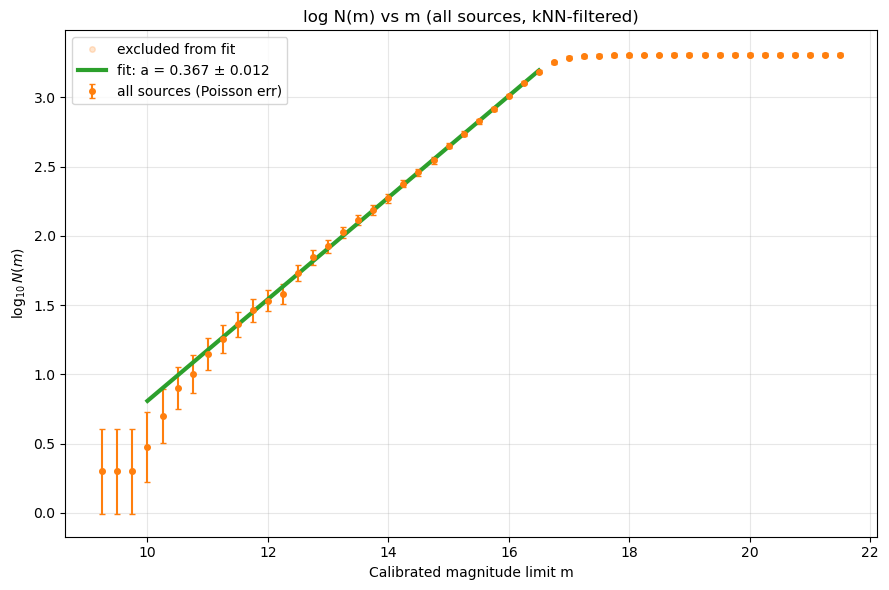

Saved plot to: C:\Users\wz2523\OneDrive - Imperial College London\Lab Astro\Astro\Astro\Fits_Data\outputs\logN_all_envelope_fit.jpg


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage as ndi
from scipy.spatial import cKDTree


INPUT_FITS = "mosaic_cleaned_enhanced.fits"
OUT_DIR = os.path.join(os.getcwd(), "outputs")
os.makedirs(OUT_DIR, exist_ok=True)
OUT_JPG = os.path.join(OUT_DIR, "logN_all_envelope_fit.jpg")

BAD_VALUE = 3421.0
SAT_LEVEL = 36000.0

# calibrated zero point
ZP = 25.3

# detection
DETECT_SIGMA = 5.0
MIN_AREA = 6

# kNN dense-halo removal
KNN_K = 10
CROWDED_FRACTION = 0.09
GRID = 10
HOT_PERCENTILE = 90.0
DILATE_CELLS = 5
MIN_REGION_CELLS = 10

# photometry: 3 diameter
PIX_SCALE = 0.258
R_AP = 1.5 / PIX_SCALE
R_IN = R_AP + 3.0
R_OUT = R_AP + 8.0
EDGE_PAD = int(np.ceil(R_OUT + 2))

# logN binning
DM = 0.25

# choose fit range manually
FIT_M_MIN = 10.0
FIT_M_MAX = 16.5



# functions
def robust_bg_sigma(image, bad_value=BAD_VALUE):
    v = image.ravel()
    v = v[np.isfinite(v) & (v != bad_value)]
    bg = float(np.median(v))
    mad = float(np.median(np.abs(v - bg)))
    sig = float(1.4826 * mad) if mad > 0 else float(np.std(v))
    return bg, sig


def detect_sources(img):
    """Threshold and connected components, returns centroids."""
    bg, sig = robust_bg_sigma(img, BAD_VALUE)
    thr = bg + DETECT_SIGMA * sig
    valid = np.isfinite(img) & (img != BAD_VALUE)
    det = valid & (img >= thr) & (img < SAT_LEVEL)

    labels, nlab = ndi.label(det, structure=np.ones((3,3), int))
    slices = ndi.find_objects(labels)

    cat = []
    for lab_id, slc in enumerate(slices, start=1):
        if slc is None:
            continue
        m = (labels[slc] == lab_id)
        area = int(m.sum())
        if area < MIN_AREA:
            continue

        sub = img[slc]
        tmp = np.where(m, sub, -np.inf)
        iy, ix = np.unravel_index(int(np.argmax(tmp)), tmp.shape)
        y_peak = slc[0].start + iy
        x_peak = slc[1].start + ix

        vals = sub[m] - bg
        vals = np.clip(vals, 0, None)
        if vals.sum() > 0:
            ys, xs = np.nonzero(m)
            y_cent = float(slc[0].start + np.sum(ys * vals) / np.sum(vals))
            x_cent = float(slc[1].start + np.sum(xs * vals) / np.sum(vals))
        else:
            y_cent, x_cent = float(y_peak), float(x_peak)

        cat.append({"x": x_cent, "y": y_cent})

    return cat, {"bg": bg, "sigma": sig, "thr": thr, "n_cat": len(cat)}


def build_region_from_points(xs, ys, shape, grid=10, hot_percentile=85.0,
                             dilate_cells=5, min_region_cells=10):
    """Make a mask of the densest region covered by given points."""
    ny, nx = shape
    gx = int(np.ceil(nx / grid))
    gy = int(np.ceil(ny / grid))
    ix = np.clip((xs / grid).astype(int), 0, gx-1)
    iy = np.clip((ys / grid).astype(int), 0, gy-1)

    H = np.zeros((gy, gx), dtype=np.int32)
    np.add.at(H, (iy, ix), 1)

    nz = H[H > 0]
    if nz.size == 0:
        return None

    thr = float(np.percentile(nz, hot_percentile))
    hot = H >= thr

    lab, nlab = ndi.label(hot, structure=np.ones((3,3), int))
    if nlab == 0:
        return None

    best = None
    best_score = -1.0
    for k in range(1, nlab+1):
        comp = (lab == k)
        score = float(H[comp].sum())
        if score > best_score:
            best_score = score
            best = comp

    if int(best.sum()) < min_region_cells:
        return None

    if dilate_cells and dilate_cells > 0:
        best = ndi.binary_dilation(best, iterations=int(dilate_cells))

    pix = np.kron(best.astype(np.uint8), np.ones((grid, grid), dtype=np.uint8)).astype(bool)
    return pix[:ny, :nx]


def knn_filter(cat, shape):
    """Remove dense halo using kNN-based density region."""
    xs = np.array([o["x"] for o in cat], float)
    ys = np.array([o["y"] for o in cat], float)
    pts = np.column_stack([xs, ys])

    if len(pts) < (KNN_K + 2):
        return cat

    tree = cKDTree(pts)
    dists, _ = tree.query(pts, k=min(KNN_K+1, len(pts)))
    dk = dists[:, -1]

    n = len(dk)
    m = max(1, int(np.floor(CROWDED_FRACTION * n)))
    idx_crowded = np.argpartition(dk, m-1)[:m]

    crowd_x = xs[idx_crowded]
    crowd_y = ys[idx_crowded]

    region = build_region_from_points(
        crowd_x, crowd_y, shape,
        grid=GRID, hot_percentile=HOT_PERCENTILE,
        dilate_cells=DILATE_CELLS, min_region_cells=MIN_REGION_CELLS
    )

    if region is None:
        keep = np.ones(n, dtype=bool)
        keep[idx_crowded] = False
        return [cat[i] for i in range(n) if keep[i]]

    xi = np.clip(xs.astype(int), 0, shape[1]-1)
    yi = np.clip(ys.astype(int), 0, shape[0]-1)
    keep = ~region[yi, xi]
    return [cat[i] for i in range(n) if keep[i]]


def aperture_photometry(img, x0, y0, r_ap, r_in, r_out):
    """Circular aperture with annulus background."""
    ny, nx = img.shape
    if x0 < EDGE_PAD or x0 > nx-1-EDGE_PAD or y0 < EDGE_PAD or y0 > ny-1-EDGE_PAD:
        return None

    rbox = int(np.ceil(r_out + 2))
    x0f, y0f = float(x0), float(y0)

    x1 = max(0, int(np.floor(x0f)) - rbox); x2 = min(nx-1, int(np.floor(x0f)) + rbox)
    y1 = max(0, int(np.floor(y0f)) - rbox); y2 = min(ny-1, int(np.floor(y0f)) + rbox)

    patch = img[y1:y2+1, x1:x2+1]
    yy, xx = np.ogrid[y1:y2+1, x1:x2+1]
    rr2 = (xx - x0f)**2 + (yy - y0f)**2

    bad = (~np.isfinite(patch)) | (patch == BAD_VALUE)
    ap  = (rr2 <= r_ap**2) & (~bad)
    ann = (rr2 >= r_in**2) & (rr2 <= r_out**2) & (~bad)

    Nap, Nann = int(ap.sum()), int(ann.sum())
    if Nap < 10 or Nann < 30:
        return None

    ap_vals = patch[ap]
    ann_vals = patch[ann]

    bkg = float(np.median(ann_vals))
    flux_net = float(ap_vals.sum() - bkg * Nap)
    if not (np.isfinite(flux_net) and flux_net > 0):
        return None
    return flux_net


def flux_to_cal_mag(F):
    return float(ZP - 2.5 * np.log10(F))


def logN_curve(mags, dm=DM):
    mags = np.asarray(mags)
    mags = mags[np.isfinite(mags)]
    mags.sort()
    if mags.size < 5:
        return None, None, None
    m_grid = np.arange(np.floor(mags.min()/dm)*dm,
                       np.ceil(mags.max()/dm)*dm + dm, dm)
    N = np.searchsorted(mags, m_grid, side="right")
    logN = np.full_like(m_grid, np.nan, dtype=float)
    ok = N > 0
    logN[ok] = np.log10(N[ok])
    return m_grid, logN, N


def poisson_sigma_log10N(N):
    N = np.asarray(N, float)
    sigma = np.full_like(N, np.nan, dtype=float)
    ok = N > 0
    sigma[ok] = 1.0 / (np.log(10.0) * np.sqrt(N[ok]))
    return sigma


def weighted_line_fit(x, y, sigma_y):
    """Weighted least-squares fit y = a x + b."""
    w = 1.0 / (sigma_y**2)
    A = np.vstack([x, np.ones_like(x)]).T
    Aw = A * np.sqrt(w)[:, None]
    yw = y * np.sqrt(w)
    (a, b), *_ = np.linalg.lstsq(Aw, yw, rcond=None)
    cov = np.linalg.inv(A.T @ (w[:, None] * A))
    sa = np.sqrt(cov[0, 0])
    sb = np.sqrt(cov[1, 1])
    return a, b, sa, sb


# MAIN
with fits.open(INPUT_FITS) as hdul:
    img = hdul[0].data.astype(float)

# detections with filter
cat_raw, det_info = detect_sources(img)
cat = knn_filter(cat_raw, img.shape)
print("[detect] raw:", det_info["n_cat"], "after kNN:", len(cat))

# photometry and calibrated mags
m_cal = []
for o in cat:
    F = aperture_photometry(img, o["x"], o["y"], R_AP, R_IN, R_OUT)
    if F is None:
        m_cal.append(np.nan)
    else:
        m_cal.append(flux_to_cal_mag(F))

m_cal = np.array(m_cal, float)
m_cal = m_cal[np.isfinite(m_cal)]
print("[phot] calibrated mags:", m_cal.size,
      "min/median/max:", np.min(m_cal), np.median(m_cal), np.max(m_cal))

# logN(m) for all sources
m_grid, logN, N = logN_curve(m_cal, dm=DM)
sigma_y = poisson_sigma_log10N(N)

# choose fit range
fitmask = (m_grid >= FIT_M_MIN) & (m_grid <= FIT_M_MAX) & np.isfinite(logN)
mf, yf, sf = m_grid[fitmask], logN[fitmask], sigma_y[fitmask]

# central weighted fit
a_c, b_c, sa_formal, sb_formal = weighted_line_fit(mf, yf, sf)

# fit to upper and lower edges of error bars
a_hi, b_hi, *_ = weighted_line_fit(mf, yf + sf, sf)
a_lo, b_lo, *_ = weighted_line_fit(mf, yf - sf, sf)

a_max = max(a_hi, a_lo)
a_min = min(a_hi, a_lo)
sigma_a_env = 0.5 * (a_max - a_min)

print(f"[fit] central slope a = {a_c:.3f}")
print(f"[fit] high-edge slope  = {a_hi:.3f}")
print(f"[fit] low-edge slope   = {a_lo:.3f}")
print(f"[fit] a_min={a_min:.3f}, a_max={a_max:.3f}, σ_a(env)={sigma_a_env:.3f}")
print(f"[fit] formal σ_a (from covariance) = {sa_formal:.3f}")
print(f"[fit] fit range: {FIT_M_MIN:.2f}–{FIT_M_MAX:.2f}, bins used = {mf.size}")

# make line for plotting
x_line = np.linspace(FIT_M_MIN, mf.max(), 300)
y_line = a_c * x_line + b_c


# PLOT
plt.figure(figsize=(9, 6))

# all data with Poisson error bars
plt.errorbar(m_grid, logN, yerr=sigma_y,
             fmt="o", ms=4, capsize=2,
             color="tab:orange",
             label="all sources (Poisson err)")

# excluded points faded
plt.plot(m_grid[~fitmask], logN[~fitmask],
         "o", ms=4, alpha=0.2, color="tab:orange", label="excluded from fit")

# best-fit line
plt.plot(x_line, y_line, lw=3, color="tab:green",
         label=f"fit: a = {a_c:.3f} ± {sigma_a_env:.3f}")

plt.xlabel("Calibrated magnitude limit m")
plt.ylabel(r"$\log_{10} N(m)$")
plt.title("log N(m) vs m (all sources, kNN-filtered)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_JPG, dpi=200, bbox_inches="tight")
plt.show()

print("Saved plot to:", OUT_JPG)
